In [25]:
from joblib import load 
from VisionUtils import *
from Manager import *
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [26]:
tf.enable_eager_execution()

In [27]:
feature_extractor = load_model("Models/FaceNet/facenet_keras.h5")
face_detector = MTCNN()
selector = load("demo/PipelineParts/feature_selector.joblib")
scaler = load("demo/PipelineParts/scaler.joblib")
gboost = load("demo/PipelineParts/GboostModel.joblib")

W0825 19:43:28.999395  7780 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [28]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def transform(f1, f2):
    cos_d = np.array(feat_distance_cosine_scalar(f1, f2.T))
    cos_d = cos_d.reshape(-1,1)
    sqr_diff = np.power(np.abs(f1- f2), 2)
    rat = f1/f2
    data = np.hstack([cos_d, sqr_diff, rat])
    data_ = scaled_data = scaler.transform(data)
    #print(scaled_data.shape)
    #data_ = selector.transform(scaled_data)
    #print(data_.shape)
    
    return data_

### Test not betsy
def verify(img_path, f1):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bb = detect_faces(img, face_detector)
    f2 = extract_feature(feature_extractor, img, bb[0])
    pred = gboost.predict(transform(f1,f2))

    if (int(pred) == 1):
        isbetsy = "betsy"
    else:
         isbetsy = "not betsy"
    
    
    a = show_img(img)
    draw_bb(a, bb[0])
    write_txt(a, (bb[0][0], bb[0][1]), isbetsy)

Add a person

In [29]:
### Load in ground truth image here
img = cv2.imread("demo/betsy/img1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bb = detect_faces(img, face_detector)

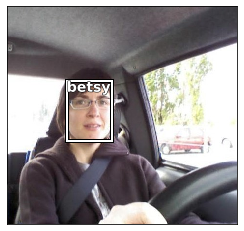

In [30]:
a = show_img(img)
draw_bb(a, bb[0])
write_txt(a, (bb[0][0], bb[0][1]),"betsy" )

In [31]:
f1 = extract_feature(feature_extractor, img, bb[0])

In [32]:
### Example input image for
path = "demo/not_betsy/img470.jpg"

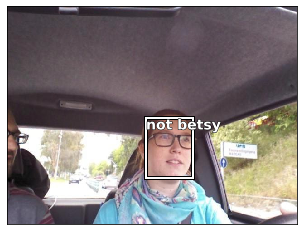

In [33]:
verify(path,f1)

In [34]:
path1 = "demo/not_betsy/img580.jpg"

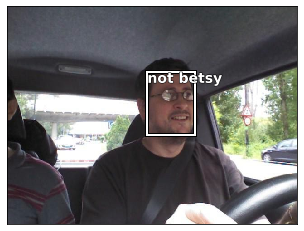

In [35]:
verify(path1, f1 )

In [36]:
path2 = "demo/betsy/img10.jpg"

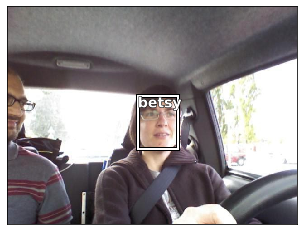

In [37]:
verify(path2, f1 )

In [38]:
   
DATABASE_PATH = "demo/database/pics/"
img_list = os.listdir(DATABASE_PATH)


In [39]:
impath = DATABASE_PATH+ img_list[0]

In [40]:
m = MTCNN()
def get_feat(face_detector , feature_extractor,  impath):
    img = plt.imread(impath)
    bb_lst = detect_faces(img, face_detector)
    if (len(bb_lst)>1):
        print("Error: more than one person detected in image")
        print("please esure only one person is in the image or try another")
    feature = extract_feature(feature_extractor, img,bb_lst[0])    
    return feature

f1 = get_feat(m, feature_extractor, DATABASE_PATH+"tyrel.jpg")
f2 = get_feat(m, feature_extractor, DATABASE_PATH+"kevon.jpg")
pred = gboost.predict(transform(f1,f2))

print(pred)

Code Test 

img = plt.imread(DATABASE_PATH+"kevon.jpg")

bb_lst = detect_faces(img, face_detector)
b = bb_lst[0]
img = cv2.rectangle(img,(b[0],b[1]),(b[0] + b[2],b[1]+ b[3]),(0,255,0),3)
plt.imshow(img)
if (len(bb_lst)>1):
    print("Error: more than one person detected in image")
    print("please esure only one person is in the image or try another")
f1 = extract_feature(feature_extractor, img,bb_lst[0])    

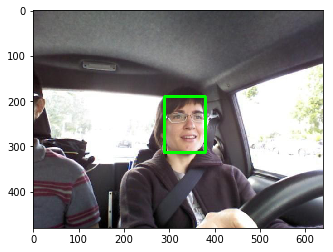

In [41]:
img = plt.imread(DATABASE_PATH+"Betsy.jpg")

bb_lst = detect_faces(img, face_detector)
b = bb_lst[0]
img = cv2.rectangle(img,(b[0],b[1]),(b[0] + b[2],b[1]+ b[3]),(0,255,0),3)
plt.imshow(img)
if (len(bb_lst)>1):
    print("Error: more than one person detected in image")
    print("please esure only one person is in the image or try another")
f1 = extract_feature(feature_extractor, img,bb_lst[0])  

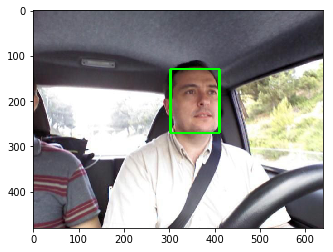

In [42]:
img = plt.imread(DATABASE_PATH+"JAKE.jpg")

bb_lst = detect_faces(img, face_detector)
b = bb_lst[0]
img = cv2.rectangle(img,(b[0],b[1]),(b[0] + b[2],b[1]+ b[3]),(0,255,0),3)
plt.imshow(img)
if (len(bb_lst)>1):
    print("Error: more than one person detected in image")
    print("please esure only one person is in the image or try another")
f2 = extract_feature(feature_extractor, img,bb_lst[0])  

In [43]:
pred = gboost.predict(transform(f1,f2))
pred1 = gboost.predict_proba(transform(f1,f2))

In [44]:
pred

array([0])

In [45]:
pred1.shape

(1, 2)

In [46]:
feat_dict = {}
for path in img_list:
    feat_dict.update({path[:-4]: get_feat(m, feature_extractor, DATABASE_PATH+path) })

In [47]:
list(feat_dict.keys())

['April', 'betsy', 'JAKE', 'jovi', 'tyrel']

In [48]:
import cv2
VID_PATH = "demo/database/face_detection.avi"
cap = cv2.VideoCapture(0)
m = MTCNN()
while(True):
    ### Capture Videos
    ret, frame = cap.read()
    frame = increase_brightness(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    #cv2.imshow('vodeos', img)
    bb_lst= detect_faces(frame, m)
    chk_dict = {"betsy": 0,  }
    for b in bb_lst:
        ### Draw Rectangle
        frame = cv2.rectangle( frame,(b[0],b[1]),(b[0] + b[2],b[1]+ b[3]),(0,255,0),3)
        ### Extract features from frame
        f2 = extract_feature(feature_extractor, frame, b)
        
        ###Check to see if detected face is in the data base
        ### and label each bb in each frame
        idp = []
        p = []
        u = []

        for k, v in feat_dict.items():
            pred = gboost.predict_proba(transform(v,f2))
            idp.append(k)
            p.append(pred[0][1])
            u.append(pred[0][0])
        if ((u[np.argmax(u)] > p[np.argmax(p)]) or( np.max(p)<0.98)) :
            name = "Unk" + str(np.max(u))
        else:
            name = idp[np.argmax(p)] + str(np.max(p))

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,name,(b[0],b[1]), font, 2,(0,0,0),2,cv2.LINE_AA)
    ### display video captured
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imshow('vodeos', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [49]:
for k, v in feat_dict.items():
    print(k)

April
betsy
JAKE
jovi
tyrel
